
# Bifacial Modeling - modelchain

Example of bifacial modeling using pvfactors and ModelChain


This example shows how to complete a bifacial modeling example using the
:py:class:`pvlib.modelchain.ModelChain` with the
:py:func:`pvlib.bifacial.pvfactors.pvfactors_timeseries` function
to transpose GHI data to both front and rear Plane of Array (POA) irradiance.

Unfortunately ``ModelChain`` does not yet support bifacial simulation
directly so we have to do the bifacial irradiance simulation ourselves.
Once the combined front + rear irradiance is known, we can pass that
to ``ModelChain`` and proceed as usual.

Future versions of pvlib may make it easier to do bifacial modeling
with ``ModelChain``.

.. attention::
   To run this example, the ``solarfactors`` package (an implementation
   of the pvfactors model) must be installed.  It can be installed with
   either ``pip install solarfactors`` or ``pip install pvlib[optional]``,
   which installs all of pvlib's optional dependencies.



In [ ]:
!pip install pvlib[optional]

In [ ]:
import pandas as pd
import pvlib
from pvlib import pvsystem
from pvlib import location
from pvlib import modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS as PARAMS
from pvlib.bifacial.pvfactors import pvfactors_timeseries
import warnings
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.iotools import get_pvgis_tmy
import matplotlib.pyplot as plt

# supressing shapely warnings that occur on import of pvfactors
#warnings.filterwarnings(action='ignore', module='pvfactors')

#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Flaine_(1600m).csv "
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Couvercle_Nivose_(2758m).csv"
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Chambery_Aix_(235m).csv"
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Bourg_Saint_Maurice_(865m).csv"
url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Aiguilles_Rouge_Nivose_(2400m).csv"
snow_data = pd.read_csv(url, index_col=0,  header=0,sep=';')


In [ ]:
print(snow_data)

           neige_au_sol  snow_total  snow_event  Unnamed: 4 Unnamed: 5  \
january            7509         146           8         NaN   latitude   
february           7032          33           3         NaN  longitude   
march              4705         323          11         NaN   timezone   
april              7804         101           7         NaN  elevation   
may                5648          15           1         NaN       name   
june               1048           0           0         NaN        NaN   
july                  0           0           0         NaN        NaN   
august                3           3           1         NaN        NaN   
september             6           3           0         NaN        NaN   
october              59          18           3         NaN        NaN   
november            547         139          10         NaN        NaN   
december           4781         236          11         NaN        NaN   

           site_parameter  
january  

In [ ]:
tmys = []
# create site location and times characteristics
#lat, lon = 36.084, -79.817
lat = snow_data['site_parameter'][0]
lon = snow_data['site_parameter'][1]
tz = snow_data['site_parameter'][2] #'ETC/GMT+1'
altitude = snow_data['site_parameter'][3]
name = snow_data['site_parameter'][4]

times = pd.date_range('2021-06-21', '2021-6-22', freq='1T', tz=tz)

# create site system characteristics


surface_azimuth = 270  #main side facing east = 90
axis_azimuth = surface_azimuth+90

axis_tilt = 90 #single axis vertical
surface_tilt = axis_tilt

gcr = 0.01
max_angle = 90

#Module Dimensions: 2382×1134×30 mm
m_width = 1.134
m_height = 2.382
number_in_string = 6
number_of_strings = 2

pvrow_height = m_height/2
pvrow_width = m_width*number_in_string*number_of_strings

albedo = 0.8
bifaciality = 0.8# from datasheet https://cdn.enfsolar.com/z/pp/2024/8/em534vircq2j33i39/dt-m-0045-f-datasheet-vertex-neg19rc-20-en-2024-b-web-0.pdf

# load temperature parameters and module/inverter specifications
temp_model_parameters = PARAMS['sapm']['open_rack_glass_glass']

cec_modules = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Modules.csv')  # Use 'CECMod' for modules
cec_inverters = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Inverters.csv')  # Use 'cecinverter' for inverters
#https://github.com/NREL/SAM/tree/develop/deploy/libraries

#cec_modules = pvsystem.retrieve_sam('CECMod')
#cec_module = cec_modules['Trina_Solar_TSM_300DEG5C_07_II_']
cec_module = cec_modules['Trina_Solar_TSM_620NEG19RC_20']
#cec_inverters = pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_7_6KTL_USL0__240V_']
#print(cec_modules.iloc[:,17270])

# create a location for site, and get solar position and clearsky data
site_location = location.Location(float(lat), float(lon), tz,altitude=float(altitude) , name=name)

weather = pvlib.iotools.get_pvgis_tmy(site_location.latitude, site_location.longitude)[0]
weather.index.name = "utc_time"
tmys.append(weather)
print(weather)


<ipython-input-13-9fc5d0a2ecdc>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lat = snow_data['site_parameter'][0]
<ipython-input-13-9fc5d0a2ecdc>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lon = snow_data['site_parameter'][1]
<ipython-input-13-9fc5d0a2ecdc>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tz = snow_data['site_parameter'][2] #'ETC/GMT+1'
<ipython-input-13-9fc5d0a2ecdc>:7: FutureWarning: Series.__getitem__ t

                           temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
utc_time                                                                        
2011-01-01 00:00:00+00:00    -10.26              84.87  0.0  0.0  0.0  221.17   
2011-01-01 01:00:00+00:00    -10.97              83.68  0.0  0.0  0.0  211.36   
2011-01-01 02:00:00+00:00    -11.67              82.49  0.0  0.0  0.0  201.55   
2011-01-01 03:00:00+00:00    -12.38              81.29  0.0  0.0  0.0  191.74   
2011-01-01 04:00:00+00:00    -13.09              80.10  0.0  0.0  0.0  181.93   
...                             ...                ...  ...  ...  ...     ...   
2005-12-31 19:00:00+00:00     -6.73              90.85  0.0  0.0  0.0  270.22   
2005-12-31 20:00:00+00:00     -7.43              89.65  0.0  0.0  0.0  260.41   
2005-12-31 21:00:00+00:00     -8.14              88.46  0.0  0.0  0.0  250.60   
2005-12-31 22:00:00+00:00     -8.85              87.26  0.0  0.0  0.0  240.79   
2005-12-31 23:00:00+00:00   

In [ ]:
#print(weather.head(20))
solar_position = site_location.get_solarposition(weather.index)
#print(solar_position.head(20))
#cs = site_location.get_clearsky(weather.index)
#print(cs.head(20))

**1 ) fisrt step**

In [ ]:
# load solar position and tracker orientation for use in pvsystem object
sat_mount = pvsystem.SingleAxisTrackerMount(axis_tilt=axis_tilt,
                                            axis_azimuth=axis_azimuth,
                                            max_angle=max_angle,
                                            backtrack=False,
                                            gcr=gcr)

# created for use in pvfactors timeseries
#orientation = sat_mount.get_orientation(solar_position['apparent_zenith'],
                                        #solar_position['azimuth'])

# get rear and front side irradiance from pvfactors transposition engine
# explicity simulate on pvarray with 3 rows, with sensor placed in middle row
# users may select different values depending on needs
irrad = pvfactors_timeseries(solar_position['azimuth'], # 2ème step IMPORTANT !!!!!!
                             solar_position['apparent_zenith'],
                             surface_azimuth,
                             surface_tilt,
                             axis_azimuth,
                             weather.index,
                             weather['dni'],
                             weather['dhi'],
                             gcr,
                             pvrow_height,
                             pvrow_width,
                             albedo,
                             n_pvrows=1,
                             index_observed_pvrow=0 #first row obervation
                             )

# Step 3 !!!!!!!!!!!!

# turn into pandas DataFrame
irrad = pd.concat(irrad, axis=1)

# create bifacial effective irradiance using aoi-corrected timeseries values
irrad['effective_irradiance'] = (
    irrad['total_abs_front'] + (irrad['total_abs_back'] * bifaciality)
)

#version pour hugo en try hard, production seulement de la façce arrire
# create bifacial effective irradiance using aoi-corrected timeseries values
#irrad['effective_irradiance'] = ((irrad['total_abs_back'] * bifaciality)
#)

/usr/local/lib/python3.11/dist-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


utc_time
2011-01-01 00:00:00+00:00         NaN
2011-01-01 01:00:00+00:00         NaN
2011-01-01 02:00:00+00:00         NaN
2011-01-01 03:00:00+00:00         NaN
2011-01-01 04:00:00+00:00         NaN
2011-01-01 05:00:00+00:00         NaN
2011-01-01 06:00:00+00:00         NaN
2011-01-01 07:00:00+00:00         NaN
2011-01-01 08:00:00+00:00    0.439244
2011-01-01 09:00:00+00:00    0.875251
2011-01-01 10:00:00+00:00    0.748870
2011-01-01 11:00:00+00:00    0.526030
2011-01-01 12:00:00+00:00    0.401405
2011-01-01 13:00:00+00:00    0.213723
2011-01-01 14:00:00+00:00    0.057441
2011-01-01 15:00:00+00:00    0.439385
2011-01-01 16:00:00+00:00         NaN
2011-01-01 17:00:00+00:00         NaN
2011-01-01 18:00:00+00:00         NaN
2011-01-01 19:00:00+00:00         NaN
dtype: float64

 Bifacial gain yearly 0.4926957947791977


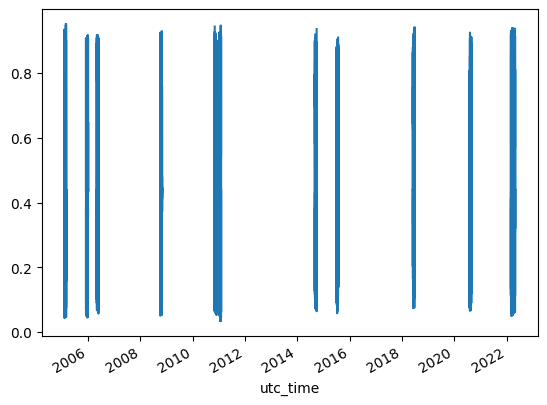

In [ ]:
BG= (bifaciality * irrad['total_abs_back'])/ irrad['effective_irradiance']

print(BG.head(20))
BG.plot()
average_value_bg = BG.mean(skipna=True)
print("\n Bifacial gain yearly",average_value_bg)

With effective irradiance, we can pass data to ModelChain for
bifacial simulation.



ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


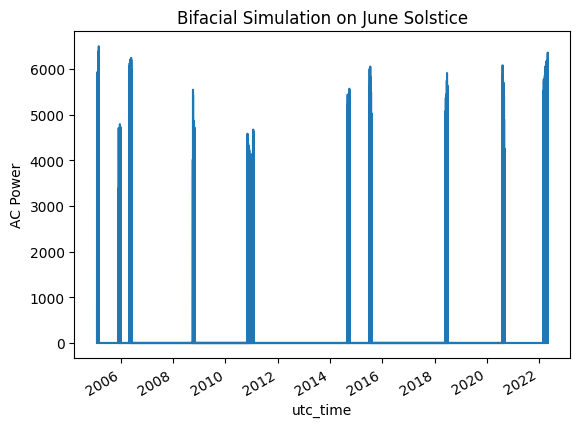

In [ ]:
array = pvsystem.Array(mount=sat_mount,
                       module_parameters=cec_module,
                       temperature_model_parameters=temp_model_parameters, modules_per_string=number_in_string, strings=number_of_strings)

# create system object
system = pvsystem.PVSystem(arrays=[array],
                           inverter_parameters=cec_inverter)

# ModelChain requires the parameter aoi_loss to have a value. pvfactors
# applies surface reflection models in the calculation of front and back
# irradiance, so assign aoi_model='no_loss' to avoid double counting
# reflections.
mc_bifi = modelchain.ModelChain(system, site_location, aoi_model='no_loss')
mc_bifi.run_model_from_effective_irradiance(irrad)

# plot results
mc_bifi.results.ac.plot(title='Bifacial Simulation on June Solstice',
                        ylabel='AC Power')
print(mc_bifi)

utc_time
2011-01-01 00:00:00+00:00    0.0
2011-01-01 01:00:00+00:00    0.0
2011-01-01 02:00:00+00:00    0.0
2011-01-01 03:00:00+00:00    0.0
2011-01-01 04:00:00+00:00    0.0
                            ... 
2005-12-31 19:00:00+00:00    0.0
2005-12-31 20:00:00+00:00    0.0
2005-12-31 21:00:00+00:00    0.0
2005-12-31 22:00:00+00:00    0.0
2005-12-31 23:00:00+00:00    0.0
Name: p_mp, Length: 8760, dtype: float64


(1990.0, 2040.0)

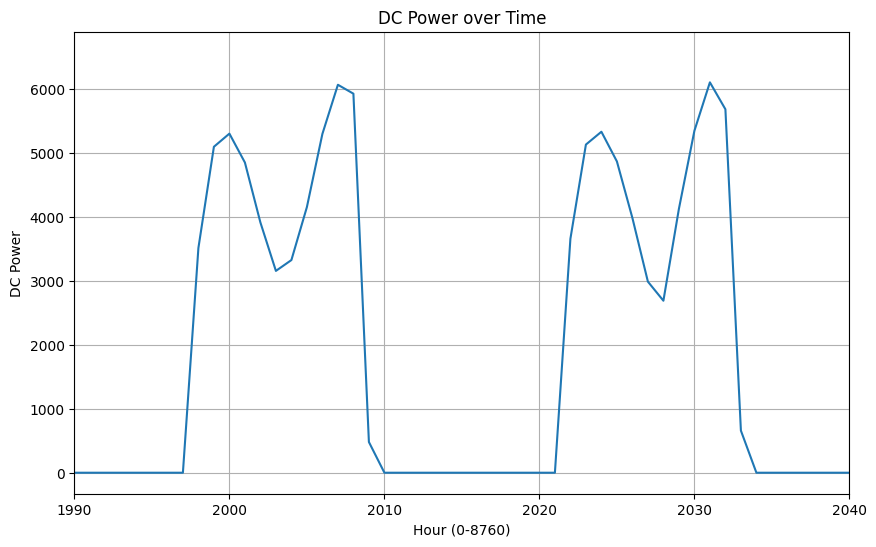

In [ ]:
# prompt: ploter la puissance dc avec les heures du fichier de 0à 8760 en bascisse

dc_power = mc_bifi.results.dc['p_mp']
print(dc_power)
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(dc_power)), dc_power)
plt.xlabel('Hour (0-8760)')
plt.ylabel('DC Power')
plt.title('DC Power over Time')
plt.grid(True)  # Add grid for better readability
plt.xlim(1990,2040) # Set x-axis limits

#plt.show()

In [ ]:
dc_power_total=mc_bifi.results.dc['p_mp'].sum()
print(dc_power_total)

12332023.412126673


HIVER

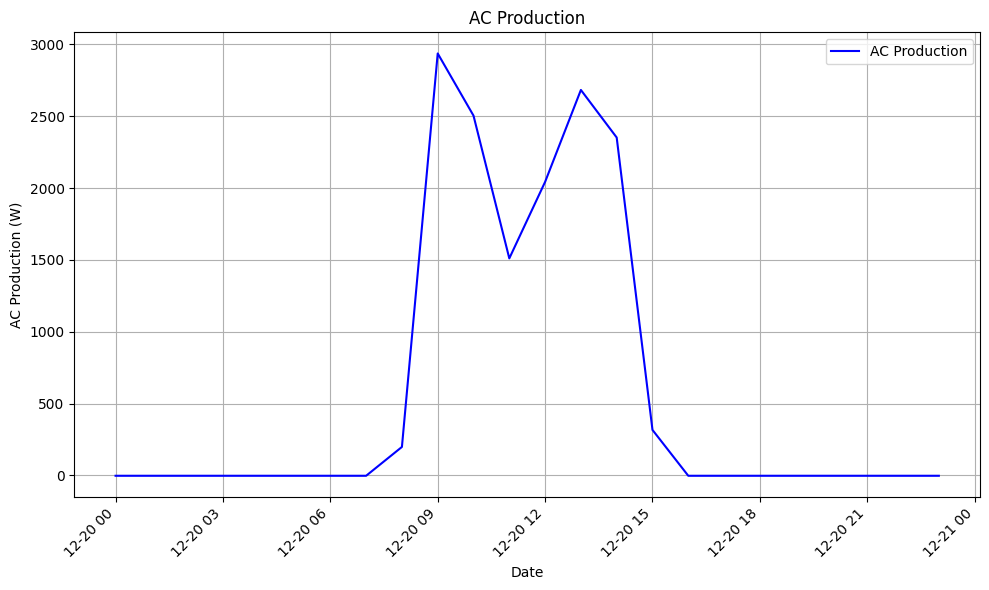

In [ ]:
# Select data for the desired hours
selected_hours_hiver = mc_bifi.results.ac.iloc[8472:8496] # changer heures

# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_hiver.index, selected_hours_hiver.values, color='b', label='AC Production')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#selected_hours_hiver.to_csv('selected_hours_hiver.csv')

In [ ]:
df1 = pd.read_csv('selected_hours_e_20 dec_EST.csv') #hiver
df2 = pd.read_csv('selected_hours_20_dec_WEST.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'selected_hours_e_20 dec_EST.csv'

In [ ]:
import matplotlib.dates as mdates
# Concatenate the DataFrames
combined_df = pd.concat([
    df1.rename(columns={'0': 'EST 90'})[['EST 90']],
    df2.rename(columns={'0': 'WEST 90'})[['WEST 90']],
], axis=1)

# Set 'Hour' as index if not already
combined_df['Hour'] = pd.to_datetime(df1['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df1.index, unit='h')
combined_df.set_index('Hour', inplace=True)


# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(combined_df.index, combined_df['EST 90'], label='EST 90', color='blue')
plt.plot(combined_df.index, combined_df['WEST 90'], label='WEST 90', color='red')

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('AC Production (W)')
plt.title('Hourly AC Production Comparison - Flaine (DEC 20th)')
plt.grid(True)
plt.legend()

# Format x-axis to show only hours
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set format to HH:MM

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

ETE

In [ ]:
# Select data for the desired hours
selected_hours_été = mc_bifi.results.ac.iloc[4152:4176] # changer heures

# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_été.index, selected_hours_été.values, color='b', label='AC Production')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#selected_hours_été.to_csv('selected_hours_été.csv')

In [ ]:
df3 = pd.read_csv('selected_hours_été_23_juin_EST.csv') #été
df4 = pd.read_csv('selected_hours_été_23_juin_WEST.csv')

In [ ]:
import matplotlib.dates as mdates
# Concatenate the DataFrames
combined_df = pd.concat([
    df3.rename(columns={'0': 'EST 90'})[['EST 90']],
    df4.rename(columns={'0': 'WEST 90'})[['WEST 90']],
], axis=1)

# Set 'Hour' as index if not already
combined_df['Hour'] = pd.to_datetime(df3['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df3.index, unit='h')
combined_df.set_index('Hour', inplace=True)


# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(combined_df.index, combined_df['EST 90'], label='EST 90', color='blue')
plt.plot(combined_df.index, combined_df['WEST 90'], label='WEST 90', color='red')

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('AC Production (W)')
plt.title('Hourly AC Production Comparison - Flaine (JUNE 23th)')
plt.grid(True)
plt.legend()

# Format x-axis to show only hours
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set format to HH:MM

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

South

In [ ]:
# Select data for the desired hours
selected_hours_south = mc_bifi.results.ac.iloc[4152:4176] # changer heures

# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_south.index, selected_hours_été.values, color='b', label='AC Production')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#selected_hours_south.to_csv('selected_hours_south.csv')

In [ ]:
df7 = pd.read_csv('selected_hours_south.csv') #été

1 string West 1 string EAST

In [ ]:
# Select data for the desired hours
selected_hours_1string = mc_bifi.results.ac.iloc[4152:4176] # changer heures

# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_1string.index, selected_hours_été.values, color='b', label='AC Production')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#selected_hours_1string.to_csv('selected_hours_1string_EAST.csv')

In [ ]:
df5 = pd.read_csv('selected_hours_1string_EAST.csv') #été
df6 = pd.read_csv('selected_hours_1string_WEST.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df3, df4, df5, df6, and df7 have a column named '0' containing the values
# and a column named 'utc_time' containing the timestamps

# Concatenate the DataFrames for the sum curve
combined_df_sum = pd.concat([
    df5.rename(columns={'0': 'EAST'})[['EAST']],
    df6.rename(columns={'0': 'WEST'})[['WEST']],
], axis=1)
combined_df_sum['Sum'] = combined_df_sum['EAST'] + combined_df_sum['WEST']

# Set 'Hour' as index for the sum curve
combined_df_sum['Hour'] = pd.to_datetime(df5['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df5.index, unit='h')
combined_df_sum.set_index('Hour', inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Plot the sum curve
plt.plot(combined_df_sum.index, combined_df_sum['Sum'], label='Sum 1 string (EAST + WEST 90°)', color='green')

# Add curves for df3, df4, and df7
# Assuming df3, df4, and df7 have the same 'utc_time' format as df5 and df6
for df, label, color in zip([df3, df4, df7], ['EAST 90°', 'WEST 90°', 'SOUTH 60°'], ['blue', 'red', 'purple']):  # Changed label here
    df['Hour'] = pd.to_datetime(df['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df.index, unit='h')
    df.set_index('Hour', inplace=True)
    plt.plot(df.index, df['0'], label=label, color=color)

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('AC Production (W)')
plt.title('Hourly AC Production Comparison - Flaine (1600 m) - June the 23rd')
plt.grid(True)
plt.legend()

# Format x-axis to show only hours
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set format to HH:MM

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
